In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network

from imblearn.keras import balanced_batch_generator

from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score
import math

from PIL import Image
from PIL import Image, ImageEnhance 
import glob
%matplotlib inline

Using TensorFlow backend.


In [2]:
total_images_train = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/')

image_height = 200#250
image_width = 400#250
batch_size = 10
no_of_epochs  = 25
train_percentage, test_percentage = 0.9, 0.05

fewimages = False

In [3]:
print(os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/'))

['train', 'test', 'val', '.DS_Store']


In [4]:
model1 = Sequential()
model1.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model1.add(Conv2D(32,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(64,(3,3),activation='relu'))  # 5
model1.add(Conv2D(64,(3,3),activation='relu'))  # 6
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128,(3,3),activation='relu'))
model1.add(Conv2D(128,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(units=128,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





model2 = Sequential()
model2.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64,(3,3),activation='relu'))  # 5
model2.add(Conv2D(64,(3,3),activation='relu'))  # 6
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(units=128,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1,activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
# model.load_weights('../input/bio-chest-x-ray-paper-simple-cnn/best_weights.hdf5')

# from keras.utils.vis_utils import plot_model
# # plot_model(model, to_file='vgg.png')
# plot_model(model)

In [6]:
data = '../input/chest-xray-pneumonia/chest_xray/chest_xray'

In [7]:
# With Validation
bac, vir = 0,0
files_paths_all = sorted(glob.glob(data + '/*/PNEUMONIA/*'))
if fewimages : files_paths_all = files_paths_all[0:100]
labels_all = []
for file in files_paths_all:
    temp = file.split('/')[-1]
    if ('bacteria' in temp): 
        bac += 1
        labels_all.append(0) # bac = 0
    elif ('virus' in temp): 
        vir += 1
        labels_all.append(1) # virus = 1
    else: labels_all.append('error')
if ('error' in labels_all): print('Error creating labels!')

print('Total:', len(labels_all), 'Bac:', bac, 'Vir:', vir)

from sklearn.model_selection import train_test_split

def train_test_val_split(files_paths_all, labels_all, train_perc=0.7, test_perc=0.2, rand_seed = 42):
    val_perc = 1-(train_perc + test_perc)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(files_paths_all, labels_all, train_size=train_perc, random_state=rand_seed)
    new_test_perc = 1/(1+val_perc/test_perc)
    val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=new_test_perc, random_state=rand_seed)
    return(train_paths, test_paths, val_paths, train_labels, test_labels, val_labels)


train_paths, test_paths, val_paths, train_labels, test_labels, val_labels = train_test_val_split(
    files_paths_all, labels_all, train_percentage, test_percentage)

print('All files =',len(files_paths_all))    
print('Train:',len(train_paths),'Test:', len(test_paths),'Validation:', len(val_paths))
print('Labels:', len(train_labels), len(test_labels), len(val_labels))

Total: 4273 Bac: 2780 Vir: 1493
All files = 4273
Train: 3845 Test: 215 Validation: 213
Labels: 3845 215 213


In [8]:
df = pd.DataFrame(train_paths)
df.to_csv('train_paths.csv', index=False)

df = pd.DataFrame(test_paths)
df.to_csv('test_paths.csv', index=False)

df = pd.DataFrame(val_paths)
df.to_csv('val_paths.csv', index=False)

df = pd.DataFrame(train_labels)
df.to_csv('train_labels.csv', index=False)

df = pd.DataFrame(test_labels)
df.to_csv('test_labels.csv', index=False)

df = pd.DataFrame(val_labels)
df.to_csv('val_labels.csv', index=False)

In [9]:
# if WithValidation == False:
#     bac, vir = 0,0
#     train_labels_all = []
#     train_files_paths_all = sorted(glob.glob(data + '/train/PNEUMONIA/*'))
#     # train_files_paths_all = train_files_paths_all[25:50]
#     for file in train_files_paths_all:
#         temp = file.split('/')[-1]
#         if ('bacteria' in temp): 
#             bac += 1
#             train_labels_all.append(0) # bac = 0
#         elif ('virus' in temp): 
#             vir += 1
#             train_labels_all.append(1) # virus = 1
#         else: train_labels_all.append('error')

#     tbac, tvir = 0,0
#     test_labels = []
#     test_files_paths = sorted(glob.glob(data + '/test/PNEUMONIA/*'))
#     # test_files_paths = test_files_paths[25:50]
#     for file in test_files_paths:
#         temp = file.split('/')[-1]
#         if ('bacteria' in temp): 
#             tbac += 1
#             test_labels.append(0) # bac = 0
#         elif ('virus' in temp): 
#             tvir += 1
#             test_labels.append(1) # virus = 1
#         else: test_labels.append('error')

#     if ('error' in train_labels_all or 'error' in test_labels): print('Error creating labels!')
#     else: print('Labels created successfully!')

#     print()    
#     print('Train set')        
#     print('Total =',len(train_labels_all),', Bac = ',bac,', Vir =',vir)

#     print('Test set')        
#     print('Total =',len(test_labels),', Bac = ',tbac,', Vir =',tvir)


In [10]:
# Balanced sub sampling

maxvir, maxbac = min(vir,bac), min(vir,bac)
uvir, ubac = 0,0
keep1, keep2 = [], []

# https://stackoverflow.com/questions/47742622/np-random-permutation-with-seed
rand = list(np.random.RandomState(seed=42).permutation(len(train_labels)))
for i in rand:
    lab = train_labels[i]
    if lab == 0: # bac
        ubac +=1        
        if ubac <= maxbac: keep1.append(i)
    elif lab == 1: # vir
        uvir +=1        
        if uvir <= maxvir: keep1.append(i)

uvir, ubac = 0,0            
for i in rand[::-1]:
    lab = train_labels[i]
    if lab == 0: # bac
        ubac +=1        
        if ubac <= maxbac: keep2.append(i)
    elif lab == 1: # vir
        uvir +=1        
        if uvir <= maxvir: keep2.append(i)
            
            
train_labels1, train_files_paths1, train_labels2, train_files_paths2 = [], [], [], []
for i in keep1:
    train_labels1.append(train_labels[i])
    train_files_paths1.append(train_paths[i])
for i in keep2:
    train_labels2.append(train_labels[i])
    train_files_paths2.append(train_paths[i])
    

In [11]:
bac,vir = 0,0
for i in train_labels1:
    if i == 0: bac+=1
    else: vir+=1

print('Train set1')        
print('Total =',len(train_labels1),', Bac = ',bac,', Vir =',vir)

bac,vir = 0,0
for i in train_labels2:
    if i == 0: bac+=1
    else: vir+=1
print('Train set2')        
print('Total =',len(train_labels2),', Bac = ',bac,', Vir =',vir)


tbac,tvir = 0,0
for i in test_labels:
    if i == 0: tbac+=1
    else: tvir+=1
print('Test set')
print('Total =',len(test_labels),', Bac = ',tbac,', Vir =',tvir)

vbac,vvir = 0,0
for i in val_labels:
    if i == 0: vbac+=1
    else: vvir+=1
print('Validation set')
print('Total =',len(val_labels),', Bac = ',vbac,', Vir =',vvir)

Train set1
Total = 2820 , Bac =  1493 , Vir = 1327
Train set2
Total = 2820 , Bac =  1493 , Vir = 1327
Test set
Total = 215 , Bac =  128 , Vir = 87
Validation set
Total = 213 , Bac =  134 , Vir = 79


In [12]:
train_steps1 = math.ceil(len(train_labels1)/batch_size)
train_steps2 = math.ceil(len(train_labels2)/batch_size)
val_steps = math.ceil(len(val_labels)/batch_size)

In [13]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)


def img_prepro(imgpath, editreport = False):
    oimg = cv2.imread(imgpath)
    edits = []

    #Crop
    x,y=oimg.shape[0:2]
    if y>x: 
        start, end = (y-x)//2, y - (y-x)//2
        crimg = oimg[:,start:end,:]
        edits.append(('crop',0,start)) # ('crop',dx,dy)

    else:  
        start, end = (x-y)//2, x - (x-y)//2
        crimg = oimg[start:end,:,:]
        edits.append(('crop',start,0))

    #Crop
    c0,c1 = crimg.shape[0:2]
    x0,x1 = int(c0*(0.5-0.3)), int(c0*(0.5+0.3)) # ypsos
    y0,y1 = 0,c1
    vis = crimg[x0:x1,y0:y1,:]
    edits.append(('crop',x0,y0)) # ('crop',dx,dy)

    # plt.imshow(vis)

    # Resize
    prev_height, prev_width = vis.shape[0:2]
    img2 = cv2.resize(vis, (image_width, image_height))
    edits.append(('resize', image_width, image_height, prev_width, prev_height))

#     plt.imshow(img2)

    if editreport == True: return(edits) 
    else:
        # Contrast
        temp = Image.fromarray(img2)
        res = change_contrast(temp, 100)
        res = np.array(res)
        img = res.astype(np.float32)/255
        return img


In [14]:
# Load Data
train_files1, val_files = [], []
for file in train_files_paths1:
    train_files1.append(img_prepro(imgpath=file, editreport = False))
print("Load 1 Complete")

train_files2 = []
for file in train_files_paths2:
    train_files2.append(img_prepro(imgpath=file, editreport = False))
print("Load 2 Complete")    

for file in val_paths:
    val_files.append(img_prepro(imgpath=file, editreport = False))

train_files1 = np.array(train_files1)
train_files2 = np.array(train_files2)
val_files = np.array(val_files)


Load 1 Complete
Load 2 Complete


In [15]:
# Data Augmentation
train_datagen = ImageDataGenerator(####rescale=1./255,
#                                    rotation_range=15,
#                                    shear_range=0.2,
#                                    zoom_range=0.2    
                                   rotation_range=10,
                                   shear_range=0.01,
#                                    zoom_range=0.1
                                   )

val_datagen = ImageDataGenerator()#rescale=1./255)


In [16]:
checkpointer1 = ModelCheckpoint(filepath="best_weights1.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

checkpointer2 = ModelCheckpoint(filepath="best_weights2.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [17]:
def lr_schedule(epoch):
    lr = 0.0001
    if epoch >= 10: #10
        lr *= 0.5
    elif epoch > 30:
        lr *= 0.2
    print('Learning rate: ', lr)
    return lr


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks1 = [lr_reducer, lr_scheduler, checkpointer1]
callbacks2 = [lr_reducer, lr_scheduler, checkpointer2]

In [18]:
training_set1 = train_datagen.flow(train_files1, train_labels1, batch_size=batch_size)
training_set2 = train_datagen.flow(train_files2, train_labels2, batch_size=batch_size)


val_set = val_datagen.flow(val_files, val_labels, batch_size=batch_size)

In [19]:
history1 = model1.fit_generator(training_set1, 
                              validation_data= val_set ,
                               steps_per_epoch= train_steps1, epochs=no_of_epochs,
                              validation_steps=val_steps,
#                               class_weight=class_weights, # for imbalanced!!!!!!!!!!!!!!
                               callbacks=callbacks1) 

Epoch 1/25
Learning rate:  0.0001
282/282 [==============================] - 46s 164ms/step - loss: 0.6942 - accuracy: 0.5369 - val_loss: 0.6898 - val_accuracy: 0.6479

Epoch 00001: val_accuracy improved from -inf to 0.64789, saving model to best_weights1.hdf5
Epoch 2/25
Learning rate:  0.0001
282/282 [==============================] - 44s 157ms/step - loss: 0.6783 - accuracy: 0.5915 - val_loss: 0.5263 - val_accuracy: 0.6620

Epoch 00002: val_accuracy improved from 0.64789 to 0.66197, saving model to best_weights1.hdf5
Epoch 3/25
Learning rate:  0.0001
282/282 [==============================] - 45s 159ms/step - loss: 0.6590 - accuracy: 0.6230 - val_loss: 0.7113 - val_accuracy: 0.6150

Epoch 00003: val_accuracy did not improve from 0.66197
Epoch 4/25
Learning rate:  0.0001
282/282 [==============================] - 44s 155ms/step - loss: 0.6435 - accuracy: 0.6454 - val_loss: 0.7929 - val_accuracy: 0.7230

Epoch 00004: val_accuracy improved from 0.66197 to 0.72300, saving model to best_w

In [20]:
history2 = model2.fit_generator(training_set2, 
#                                validation_data=(val_files,val_labels) ,
                              validation_data= val_set ,
                               steps_per_epoch= train_steps2, epochs=no_of_epochs,
                              validation_steps=val_steps,
#                               class_weight=class_weights, # for imbalanced!!!!!!!!!!!!!!
                               callbacks=callbacks2) 

Epoch 1/25
Learning rate:  0.0001
282/282 [==============================] - 45s 158ms/step - loss: 0.6899 - accuracy: 0.5493 - val_loss: 0.6460 - val_accuracy: 0.6291

Epoch 00001: val_accuracy improved from -inf to 0.62911, saving model to best_weights2.hdf5
Epoch 2/25
Learning rate:  0.0001
282/282 [==============================] - 44s 155ms/step - loss: 0.6722 - accuracy: 0.5936 - val_loss: 0.7659 - val_accuracy: 0.6854

Epoch 00002: val_accuracy improved from 0.62911 to 0.68545, saving model to best_weights2.hdf5
Epoch 3/25
Learning rate:  0.0001
282/282 [==============================] - 44s 155ms/step - loss: 0.6534 - accuracy: 0.6262 - val_loss: 0.5640 - val_accuracy: 0.6573

Epoch 00003: val_accuracy did not improve from 0.68545
Epoch 4/25
Learning rate:  0.0001
282/282 [==============================] - 44s 155ms/step - loss: 0.6321 - accuracy: 0.6468 - val_loss: 0.8017 - val_accuracy: 0.6948

Epoch 00004: val_accuracy improved from 0.68545 to 0.69484, saving model to best_w

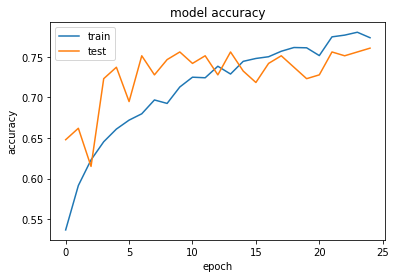

In [21]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

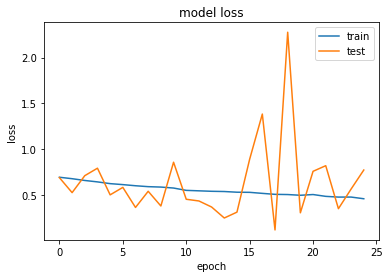

In [22]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

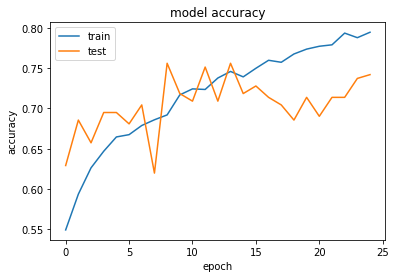

In [23]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

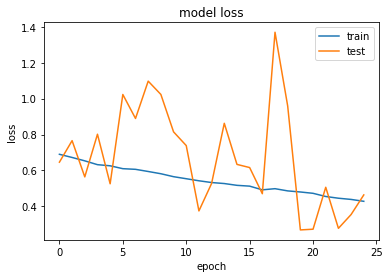

In [24]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [25]:
# For predictions (not best)

test_files = []
for file in test_paths:
    test_files.append(img_prepro(imgpath=file, editreport = False))
test_files = np.array(test_files)

pred_class1 = model1.predict_classes(test_files)
pred_class2 = model1.predict_classes(test_files)

pred_prob1 = model2.predict(test_files)
pred_prob2 = model2.predict(test_files)

In [26]:
# Final Predictions

y_pred = pred_prob1.copy()

for i in range(len(y_pred)):
    confidence1 = abs(pred_prob1[i] - 0.5)
    confidence2 = abs(pred_prob2[i] - 0.5)
    if confidence1 > confidence2: y_pred[i] = pred_class1[i]
    else: y_pred[i] = pred_class2[i]
        

Confusion Matrix : 



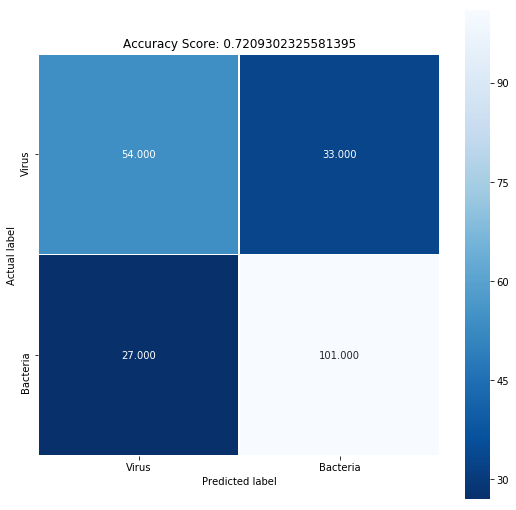

In [27]:
print('Confusion Matrix : \n')
cm = confusion_matrix(test_labels, y_pred,labels = [1,0])
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
ax.set_ylabel('Actual label');
ax.set_xlabel('Predicted label');
target_names = ['Virus','Bacteria']
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
accuracy = np.sum(test_labels == y_pred.T)/len(y_pred)
ax.set_title('Accuracy Score: {}'.format(accuracy))
fig.show()

In [28]:
print('Balanced Acc:')
print(balanced_accuracy_score(test_labels, y_pred))

Balanced Acc:
0.7048760775862069


In [29]:
# AOC needs confidence!!!!!!!!!!!!!!